# Step 2A: Feature Exploration

The scenario is constructed as a pipeline flow, where each notebook is optimized to perform in a batch setting for each of the ingest, feature engineering, model building, model scoring operations. To accomplish this, `2a_feature_engineering` notebook is designed to be used to generate a general data set for any of the training, calibrate, test or scoring operations. In this scenario, we use a temporal split strategy for these operations, so the notebook parameters are used to set date range filtering. The notebook creates a labeled data set using the parameters start_date and to_date to select the time period for training. This data set is stored in the features_table specified. After this cell completes, you should see the dataset under the Databricks Data icon.

This notebook examines data created in the `2a_feature_engineering` notebook. The notebook is provided to aid the understanding of the feature engineering steps executed in `2a_feature_engineering` and can be used for debugging pourposes. The notebook  does reproduce many of the operations done before but outputs tables of intermediate results that are not saved in the previous notebook. We do this in a separate notebook to optimize the performance in the `2a_feature_engineering` notebook.

According to [Wikipedia, Feature engineering](https://en.wikipedia.org/wiki/Feature_engineering) is the process of using domain knowledge of the data to create features that make machine learning algorithms work. Feature engineering is fundamental to the application of machine learning, and is both difficult and expensive. 

The `2a_feature_engineering`  notebook will load the data sets created in the **Data Ingestion** notebook (`1_data_ingestion`) and combine them to create a single data set of features (variables) that can be used to infer a machines's health condition over time. This notebook examines both the raw data, and the features data set indicated above to understand how the features and labels are constructed. 

**Note:** This notebook should take less than a minute to execute all cells, depending on the compute configuration you have setup.

In [2]:
## Setup our environment by importing required libraries
import pyspark

import pandas as pd
import pyspark.sql.functions as F
# For creating some preliminary EDA plots.
# %matplotlib inline
from ggplot import *
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import StringIndexer
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, unix_timestamp, round
from pyspark.sql.functions import datediff
from pyspark.sql.types import DoubleType
from pyspark.sql.window import Window

spark = SparkSession.builder.getOrCreate()

# These file names detail which blob each files is stored under. 
MACH_DATA = 'machines_data'
MAINT_DATA = 'maint_data'
ERROR_DATA = 'errors_data'
TELEMETRY_DATA = 'telemetry_data'
FAILURE_DATA = 'failure_data'

Specify what data we want to examine using data bricks parameters.

In [4]:
dbutils.widgets.removeAll()
dbutils.widgets.text("features","training_data")

dbutils.widgets.text("start_date", '2000-01-01')

dbutils.widgets.text("to_date", '2015-10-30')

## Feature engineering 

Our feature engineering will combine the different data sources together to create a single data set of features (variables) that can be used to infer a machines's health condition over time. The ultimate goal is to generate a single record for each time unit within each asset. The record combines features and labels to be fed into the machine learning algorithm.

Predictive maintenance take historical data, marked with a timestamp, to predict current health of a component and the probability of failure within some future window of time. These problems can be characterised as a _classification method_ involving _time series_ data. Time series, since we want to use historical observations to predict what will happen in the future. Classification, because we classify the future as having a probability of failure.

### Lag features

There are many ways of creating features from the time series data. We start by dividing the duration of data collection into time units where each record belongs to a single point in time for each asset. The measurement unit for is in fact arbitrary. Time can be in seconds, minutes, hours, days, or months, or it can be measured in cycles, miles or transactions. The measurement choice is typically specific to the use case domain.

Additionally, the time unit does not have to be the same as the frequency of data collection. For example, if temperature values were being collected every 10 seconds, picking a time unit of 10 seconds for analysis may inflate the number of examples without providing any additional information if the temperature changes slowly. A better strategy may be to average the temperature over a longer time horizon which might better capture variations that contribute to the target outcome.

Once we set the frequency of observations, we want to look for trends within measures, over time, in order to predict performance degradation, which we would like to connect to how likely a component will fail. We create features for these trends within each record using time lags over previous observations to check for these performance changes. The lag window size $W$ is a hyper parameter that we can optimize. The following figures indicate a _rolling aggregate window_ strategy for averaging a measure $t_i$ over a window $W = 3$ previous observations. We are note constrained to averages, we can roll aggregates over counts, average, the standard deviation, outliers based on standard deviations, CUSUM measures, minimum and maximum values for the window. We could also use a tumbling window approach, if we were interested in a different time window measure than the frequncy of the observations. For example, we might have obersvations evert 6 or 12 hours, but want to create features aligned on a day or week basis. 

In the following sections, we will build our features using only a rolling strategy to demonstrate the process. We align our data, and then build features along those normalized observations times. We start with the telemetry data.

## Telemetry features

Because the telemetry data set is the largest time series data we have, we start feature engineering here. The telemetry data has 8761000 hourly observations for out 1000 machines. We can improve the model performance by aligning our data by aggregating average sensor measures on a tumbling 12 hour window. In this case we replace the raw data with the tumbling window data, reducing the sensor data to 731000 observations. This will directly reduce the computaton time required to do the feature engineering, labeling and modeling required for our solution.    

Once we have the reduced data, we set up our lag features by compute rolling aggregate measures such as mean, standard deviation, minimum, maximum, etc. to represent the short term history of the telemetry over time. 

The following code blocks alignes the data on 12 hour observations and calculates a rolling mean and standard deviation of the telemetry data over the last 12, 24 and 36 hour lags.

In [7]:
TO_DATE = dbutils.widgets.get("to_date")
START_DATE = dbutils.widgets.get("start_date")
telemetry = spark.table(TELEMETRY_DATA).where(F.col("datetime") <= TO_DATE).where(F.col("datetime")  > START_DATE).cache()

# rolling mean and standard deviation
# Temporary storage for rolling means
tel_mean = telemetry

# Which features are we interested in telemetry data set
rolling_features = ['volt','rotate', 'pressure', 'vibration']
      
# n hours = n * 3600 seconds  
time_val = 12 * 3600

# Choose the time_val hour timestamps to align the data
# dt_truncated looks at the column named "datetime" in the current data set.
# remember that Spark is lazy... this doesn't execute until it is in a withColumn statement.
dt_truncated = ((round(unix_timestamp(col("datetime")) / time_val) * time_val).cast("timestamp"))

In [8]:
# We choose windows for our rolling windows 12hrs, 24 hrs and 36 hrs
lags = [12, 24, 36]

# align the data
for lag_n in lags:
    wSpec = Window.partitionBy('machineID').orderBy('datetime').rowsBetween(1-lag_n, 0)
    for col_name in rolling_features:
        tel_mean = tel_mean.withColumn(col_name+'_rollingmean_'+str(lag_n), 
                                       F.avg(col(col_name)).over(wSpec))
        tel_mean = tel_mean.withColumn(col_name+'_rollingstd_'+str(lag_n), 
                                       F.stddev(col(col_name)).over(wSpec))

# Calculate lag values...
telemetry_feat = (tel_mean.withColumn("dt_truncated", dt_truncated)
                  .drop('volt', 'rotate', 'pressure', 'vibration')
                  .fillna(0)
                  .groupBy("machineID","dt_truncated")
                  .agg(F.mean('volt_rollingmean_12').alias('volt_rollingmean_12'),
                       F.mean('rotate_rollingmean_12').alias('rotate_rollingmean_12'), 
                       F.mean('pressure_rollingmean_12').alias('pressure_rollingmean_12'), 
                       F.mean('vibration_rollingmean_12').alias('vibration_rollingmean_12'), 
                       F.mean('volt_rollingmean_24').alias('volt_rollingmean_24'),
                       F.mean('rotate_rollingmean_24').alias('rotate_rollingmean_24'), 
                       F.mean('pressure_rollingmean_24').alias('pressure_rollingmean_24'), 
                       F.mean('vibration_rollingmean_24').alias('vibration_rollingmean_24'),
                       F.mean('volt_rollingmean_36').alias('volt_rollingmean_36'),
                       F.mean('vibration_rollingmean_36').alias('vibration_rollingmean_36'),
                       F.mean('rotate_rollingmean_36').alias('rotate_rollingmean_36'), 
                       F.mean('pressure_rollingmean_36').alias('pressure_rollingmean_36'), 
                       F.stddev('volt_rollingstd_12').alias('volt_rollingstd_12'),
                       F.stddev('rotate_rollingstd_12').alias('rotate_rollingstd_12'), 
                       F.stddev('pressure_rollingstd_12').alias('pressure_rollingstd_12'), 
                       F.stddev('vibration_rollingstd_12').alias('vibration_rollingstd_12'), 
                       F.stddev('volt_rollingstd_24').alias('volt_rollingstd_24'),
                       F.stddev('rotate_rollingstd_24').alias('rotate_rollingstd_24'), 
                       F.stddev('pressure_rollingstd_24').alias('pressure_rollingstd_24'), 
                       F.stddev('vibration_rollingstd_24').alias('vibration_rollingstd_24'),
                       F.stddev('volt_rollingstd_36').alias('volt_rollingstd_36'),
                       F.stddev('rotate_rollingstd_36').alias('rotate_rollingstd_36'), 
                       F.stddev('pressure_rollingstd_36').alias('pressure_rollingstd_36'), 
                       F.stddev('vibration_rollingstd_36').alias('vibration_rollingstd_36'), ))
print(telemetry_feat.count())
telemetry_feat.where((col("machineID") == 1)).limit(10).toPandas().head(10)

604000
 Out[ 110 ]: 
 machineID dt_truncated volt_rollingmean_12 rotate_rollingmean_12 \
0 1 2015-04-02 12:00:00 172.270947 453.797903 
1 1 2015-05-12 00:00:00 171.869404 453.529162 
2 1 2015-07-26 12:00:00 167.325797 450.548728 
3 1 2015-08-04 00:00:00 170.231819 482.393571 
4 1 2015-08-23 12:00:00 170.203712 425.094036 
5 1 2015-02-16 12:00:00 167.881679 459.764609 
6 1 2015-05-25 00:00:00 166.260042 461.347637 
7 1 2015-08-06 00:00:00 170.918990 468.912300 
8 1 2015-10-06 00:00:00 168.818354 448.623504 
9 1 2015-10-02 00:00:00 169.517717 441.908249 

 pressure_rollingmean_12 vibration_rollingmean_12 volt_rollingmean_24 \
0 100.483543 39.492142 171.338531 
1 100.214013 40.171795 171.649903 
2 96.380156 41.093641 168.417015 
3 98.709572 39.771546 171.876957 
4 101.529310 39.173365 167.913767 
5 95.996968 41.355194 173.957011 
6 98.472551 39.769579 169.719221 
7 100.279474 41.029800 171.800474 
8 99.988661 38.238438 172.146870 
9 99.834006 38.102767 170.834222 

 rotate_rollingmean_24 pressure_rollingmean_24 vibration_rollingmean_24 \
0 447.862397 100.398683 39.738176 
1 458.103907 101.813178 40.830119 
2 446.610707 97.754618 39.830570 
3 473.301415 103.358692 43.025796 
4 447.531697 100.026931 38.672964 
5 452.269318 99.137917 40.716012 
6 445.965330 96.691888 39.633974 
7 457.864512 101.703721 40.571458 
8 451.556090 99.220352 38.986845 
9 436.229556 100.320677 39.044301 

 ... pressure_rollingstd_12 vibration_rollingstd_12 \
0 ... 0.553654 0.759006 
1 ... 1.950677 0.954435 
2 ... 0.948548 0.460620 
3 ... 1.007066 0.634358 
4 ... 1.640248 0.397124 
5 ... 1.038664 0.734094 
6 ... 0.514229 1.063869 
7 ... 0.729317 0.189013 
8 ... 0.975165 0.744556 
9 ... 0.546592 0.723793 

 volt_rollingstd_24 rotate_rollingstd_24 pressure_rollingstd_24 \
0 1.007532 3.219369 0.223788 
1 0.732750 2.007912 1.015522 
2 0.834651 1.777865 0.496723 
3 0.546013 1.609741 1.535208 
4 0.951870 4.648390 1.638073 
5 1.594118 4.929011 0.532804 
6 0.540275 2.555781 0.633106 
7 0.333097 2.581715 0.752639 
8 0.667294 2.479397 0.349998 
9 1.042514 0.625751 0.466541 

 vibration_rollingstd_24 volt_rollingstd_36 rotate_rollingstd_36 \
0 0.157623 0.629986 0.722444 
1 0.472419 0.561696 0.988960 
2 0.181640 0.458351 1.382999 
3 0.333413 0.546630 1.585655 
4 0.297089 0.823227 2.742029 
5 0.139801 1.130919 3.430454 
6 0.380793 0.322601 1.204358 
7 0.199769 0.786033 1.717248 
8 0.155386 0.568806 1.005593 
9 0.190865 0.692236 1.904503 

 pressure_rollingstd_36 vibration_rollingstd_36 
0 0.481365 0.088545 
1 0.580570 0.306208 
2 0.176032 0.107555 
3 0.186535 0.133264 
4 0.467837 0.189906 
5 0.376233 0.134925 
6 0.521838 0.303534 
7 0.645149 0.165356 
8 0.256024 0.215119 
9 0.343368 0.257992 

[10 rows x 26 columns]

## Errors features

Like telemetry data, errors come with timestamps. An important difference is that the error IDs are categorical values and should not be averaged over time intervals like the telemetry measurements. Instead, we count the number of errors of each type within a lag window. 

Again, we align the error counts data by tumbling over the 12 hour window using a join with telemetry data.

In [10]:
errors = spark.table(ERROR_DATA).where(F.col("datetime") <= TO_DATE).where(F.col("datetime")  > START_DATE)

# create a column for each errorID 
error_ind = (errors.groupBy("machineID","datetime","errorID").pivot('errorID')
             .agg(F.count('machineID').alias('dummy')).drop('errorID').fillna(0)
             .groupBy("machineID","datetime")
             .agg(F.sum('error1').alias('error1sum'), 
                  F.sum('error2').alias('error2sum'), 
                  F.sum('error3').alias('error3sum'), 
                  F.sum('error4').alias('error4sum'), 
                  F.sum('error5').alias('error5sum')))

# join the telemetry data with errors
error_count = (telemetry.join(error_ind, 
                              ((telemetry['machineID'] == error_ind['machineID']) 
                               & (telemetry['datetime'] == error_ind['datetime'])), "left")
               .drop('volt', 'rotate', 'pressure', 'vibration')
               .drop(error_ind.machineID).drop(error_ind.datetime)
               .fillna(0))

error_features = ['error1sum','error2sum', 'error3sum', 'error4sum', 'error5sum']

wSpec = Window.partitionBy('machineID').orderBy('datetime').rowsBetween(1-24, 0)
for col_name in error_features:
    # We're only interested in the erros in the previous 24 hours.
    error_count = error_count.withColumn(col_name+'_rollingmean_24', 
                                         F.avg(col(col_name)).over(wSpec))

error_feat = (error_count.withColumn("dt_truncated", dt_truncated)
              .drop('error1sum', 'error2sum', 'error3sum', 'error4sum', 'error5sum').fillna(0)
              .groupBy("machineID","dt_truncated")
              .agg(F.mean('error1sum_rollingmean_24').alias('error1sum_rollingmean_24'), 
                   F.mean('error2sum_rollingmean_24').alias('error2sum_rollingmean_24'), 
                   F.mean('error3sum_rollingmean_24').alias('error3sum_rollingmean_24'), 
                   F.mean('error4sum_rollingmean_24').alias('error4sum_rollingmean_24'), 
                   F.mean('error5sum_rollingmean_24').alias('error5sum_rollingmean_24')))

print(error_feat.count())
error_feat.limit(10).toPandas().head(10)

604000
 Out[ 111 ]: 
 machineID dt_truncated error1sum_rollingmean_24 \
0 558 2015-01-15 12:00:00 0.0 
1 65 2015-04-17 12:00:00 0.0 
2 65 2015-05-06 00:00:00 0.0 
3 65 2015-05-14 12:00:00 0.0 
4 65 2015-07-01 00:00:00 0.0 
5 65 2015-08-13 00:00:00 0.0 
6 191 2015-03-20 12:00:00 0.0 
7 191 2015-04-17 00:00:00 0.0 
8 191 2015-05-17 12:00:00 0.0 
9 418 2015-05-23 00:00:00 0.0 

 error2sum_rollingmean_24 error3sum_rollingmean_24 \
0 0.0 0.0 
1 0.0 0.0 
2 0.0 0.0 
3 0.0 0.0 
4 0.0 0.0 
5 0.0 0.0 
6 0.0 0.0 
7 0.0 0.0 
8 0.0 0.0 
9 0.0 0.0 

 error4sum_rollingmean_24 error5sum_rollingmean_24 
0 0.0 0.0 
1 0.0 0.0 
2 0.0 0.0 
3 0.0 0.0 
4 0.0 0.0 
5 0.0 0.0 
6 0.0 0.0 
7 0.0 0.0 
8 0.0 0.0 
9 0.0 0.0

## Days since last replacement from maintenance 

A crucial data set in this example is the use of maintenance records, which contain the information regarding component replacement. Possible features from this data set can be the number of replacements of each component over time or to calculate how long it has been since a component has been replaced. Replacement time is expected to correlate better with component failures since the longer a component is used, the more degradation would be expected.

As a side note, creating lagging features from maintenance data is not straight forward. This type of ad-hoc feature engineering is very common in predictive maintenance as domain knowledge plays a crucial role in understanding the predictors of a failure problem. In the following code blocks, the days since last component replacement are calculated for each component from the maintenance data. We start by counting the component replacements for the set of machines.

In [12]:
maint = spark.table(MAINT_DATA).where(F.col("datetime") <= TO_DATE).where(F.col("datetime")  > START_DATE)

# create a column for each component replacement
maint_replace = (maint.groupBy("machineID","datetime","comp").pivot('comp')
                 .agg(F.count('machineID').alias('dummy')).fillna(0)
                 .groupBy("machineID","datetime")
                 .agg(F.sum('comp1').alias('comp1sum'), 
                      F.sum('comp2').alias('comp2sum'), 
                      F.sum('comp3').alias('comp3sum'),
                      F.sum('comp4').alias('comp4sum'))
                 .withColumnRenamed('datetime','datetime_maint'))

print(maint_replace.count())
maint_replace.limit(10).toPandas().head(10)

21310
 Out[ 112 ]: 
 machineID datetime_maint comp1sum comp2sum comp3sum comp4sum
0 567 2015-09-17 06:00:00 0 0 0 1
1 852 2015-06-14 06:00:00 0 0 1 0
2 942 2015-09-23 06:00:00 0 0 1 1
3 457 2014-07-31 06:00:00 0 0 1 0
4 262 2015-06-28 06:00:00 0 1 1 0
5 963 2015-02-26 06:00:00 1 0 0 0
6 279 2014-06-01 06:00:00 0 0 0 1
7 151 2015-06-13 06:00:00 1 0 0 0
8 240 2015-09-02 06:00:00 0 1 0 1
9 179 2015-02-17 06:00:00 1 0 0 1

Replacement features are then created by tracking the number of days between each component replacement. We'll repeat these calculations for each of the four components and join them together into a maintenance feature table.

First component number 1 (`comp1`):

In [14]:
# We want to align the component information on telemetry features timestamps.
telemetry_times = (telemetry_feat.select(telemetry_feat.machineID, telemetry_feat.dt_truncated)
                   .withColumnRenamed('dt_truncated','datetime_tel'))

def grab_component_records(self, telemetry_times, comp_sum="comp1sum", sincelastcomp_="sincelastcomp1",
                          comp_a='comp2sum', comp_b='comp3sum', comp_c='comp4sum'):
    maint_comp = (self.where(col(comp_sum) == '1').withColumnRenamed('datetime', 'datetime_maint')
                  .drop(comp_a, comp_b, comp_c))
    # Within each machine, get the last replacement date for each timepoint
    maint_tel_comp = (telemetry_times.join(maint_comp,
                                           ((telemetry_times['machineID'] == maint_comp['machineID'])
                                            & (telemetry_times['datetime_tel'] > maint_comp['datetime_maint'])
                                            & (maint_comp[(comp_sum)] == '1')))
                      .drop(maint_comp.machineID))
    # Calculate the number of days between replacements
    return (maint_tel_comp.withColumn(sincelastcomp_,
                                      datediff(maint_tel_comp.datetime_tel, maint_tel_comp.datetime_maint))
            .drop(maint_tel_comp.datetime_maint).drop(maint_tel_comp[comp_sum]))

pyspark.sql.dataframe.DataFrame.grab_component_records = grab_component_records

# Grab component 1 records
comp1 = maint_replace.grab_component_records(telemetry_times, comp_sum="comp1sum", sincelastcomp_="sincelastcomp1",
                                            comp_a='comp2sum', comp_b='comp3sum', comp_c='comp4sum')
comp2 = maint_replace.grab_component_records(telemetry_times, comp_sum="comp2sum", sincelastcomp_="sincelastcomp2",
                                            comp_a='comp1sum', comp_b='comp3sum', comp_c='comp4sum')
comp3 = maint_replace.grab_component_records(telemetry_times, comp_sum="comp3sum", sincelastcomp_="sincelastcomp3",
                                            comp_a='comp1sum', comp_b='comp2sum', comp_c='comp4sum')
comp4 = maint_replace.grab_component_records(telemetry_times, comp_sum="comp4sum", sincelastcomp_="sincelastcomp4",
                                            comp_a='comp1sum', comp_b='comp2sum', comp_c='comp3sum')

In [15]:

print(comp1.count())
comp1.filter(comp1.machineID == '625').orderBy(comp1.datetime_tel).limit(20).toPandas().head(20)

2311356
 Out[ 114 ]: 
 machineID datetime_tel sincelastcomp1
0 625 2015-01-01 12:00:00 94
1 625 2015-01-02 00:00:00 95
2 625 2015-01-02 12:00:00 95
3 625 2015-01-03 00:00:00 96
4 625 2015-01-03 12:00:00 96
5 625 2015-01-04 00:00:00 97
6 625 2015-01-04 12:00:00 97
7 625 2015-01-05 00:00:00 98
8 625 2015-01-05 12:00:00 98
9 625 2015-01-06 00:00:00 99
10 625 2015-01-06 12:00:00 99
11 625 2015-01-07 00:00:00 100
12 625 2015-01-07 12:00:00 100
13 625 2015-01-08 00:00:00 101
14 625 2015-01-08 12:00:00 101
15 625 2015-01-09 00:00:00 102
16 625 2015-01-09 12:00:00 102
17 625 2015-01-10 00:00:00 103
18 625 2015-01-10 12:00:00 103
19 625 2015-01-11 00:00:00 104

Then component 2 (`comp2`):

In [17]:

print(comp2.count())
comp2.filter(comp2.machineID == '625').orderBy(comp2.datetime_tel).limit(5).toPandas().head(5)

2326440
 Out[ 115 ]: 
 machineID datetime_tel sincelastcomp2
0 625 2015-01-01 12:00:00 19
1 625 2015-01-02 00:00:00 20
2 625 2015-01-02 12:00:00 20
3 625 2015-01-03 00:00:00 21
4 625 2015-01-03 12:00:00 21

Then component 3 (`comp3`):

In [19]:

print(comp3.count())
comp3.filter(comp3.machineID == '625').orderBy(comp3.datetime_tel).limit(5).toPandas().head(5)

2377026
 Out[ 116 ]: 
 machineID datetime_tel sincelastcomp3
0 625 2015-01-01 12:00:00 19
1 625 2015-01-02 00:00:00 20
2 625 2015-01-02 12:00:00 20
3 625 2015-01-03 00:00:00 21
4 625 2015-01-03 12:00:00 21

and component 4 (`comp4`):

In [21]:

print(comp4.count())
comp4.filter(comp4.machineID == '625').orderBy(comp4.datetime_tel).limit(5).toPandas().head(5)

2322384
 Out[ 117 ]: 
 machineID datetime_tel sincelastcomp4
0 625 2015-01-01 12:00:00 139
1 625 2015-01-02 00:00:00 140
2 625 2015-01-02 12:00:00 140
3 625 2015-01-03 00:00:00 141
4 625 2015-01-03 12:00:00 141

Now, we join the four component replacement tables together. Once joined, align the data by tumbling the average across 12 hour observation windows.

In [23]:
# Join component 3 and 4
comp3_4 = (comp3.join(comp4, ((comp3['machineID'] == comp4['machineID']) 
                              & (comp3['datetime_tel'] == comp4['datetime_tel'])), "left")
           .drop(comp4.machineID).drop(comp4.datetime_tel))

# Join component 2 to 3 and 4
comp2_3_4 = (comp2.join(comp3_4, ((comp2['machineID'] == comp3_4['machineID']) 
                                  & (comp2['datetime_tel'] == comp3_4['datetime_tel'])), "left")
             .drop(comp3_4.machineID).drop(comp3_4.datetime_tel))

# Join component 1 to 2, 3 and 4
comps_feat = (comp1.join(comp2_3_4, ((comp1['machineID'] == comp2_3_4['machineID']) 
                                      & (comp1['datetime_tel'] == comp2_3_4['datetime_tel'])), "left")
               .drop(comp2_3_4.machineID).drop(comp2_3_4.datetime_tel)
               .groupBy("machineID", "datetime_tel")
               .agg(F.max('sincelastcomp1').alias('sincelastcomp1'), 
                    F.max('sincelastcomp2').alias('sincelastcomp2'), 
                    F.max('sincelastcomp3').alias('sincelastcomp3'), 
                    F.max('sincelastcomp4').alias('sincelastcomp4'))
               .fillna(0))

# Choose the time_val hour timestamps to align the data
dt_truncated = ((round(unix_timestamp(col("datetime_tel")) / time_val) * time_val).cast("timestamp"))

# Collect data
maint_feat = (comps_feat.withColumn("dt_truncated", dt_truncated)
              .groupBy("machineID","dt_truncated")
              .agg(F.mean('sincelastcomp1').alias('comp1sum'), 
                   F.mean('sincelastcomp2').alias('comp2sum'), 
                   F.mean('sincelastcomp3').alias('comp3sum'), 
                   F.mean('sincelastcomp4').alias('comp4sum')))

print(maint_feat.count())
maint_feat.limit(10).toPandas().head(10)

604000
 Out[ 118 ]: 
 machineID dt_truncated comp1sum comp2sum comp3sum comp4sum
0 1 2015-04-02 12:00:00 200.0 200.0 140.0 275.0
1 1 2015-05-12 00:00:00 240.0 240.0 180.0 315.0
2 1 2015-07-26 12:00:00 315.0 315.0 255.0 390.0
3 1 2015-08-04 00:00:00 324.0 324.0 264.0 399.0
4 1 2015-08-23 12:00:00 343.0 343.0 283.0 418.0
5 2 2015-05-31 00:00:00 334.0 199.0 229.0 304.0
6 2 2015-08-23 00:00:00 418.0 283.0 313.0 388.0
7 2 2015-09-14 12:00:00 440.0 305.0 335.0 410.0
8 3 2015-02-17 12:00:00 261.0 261.0 201.0 156.0
9 3 2015-04-09 12:00:00 312.0 312.0 252.0 207.0

## Machine features

The machine features capture specifics of the individuals. These can be used without further modification since it include descriptive information about the type of each machine and its age (number of years in service). If the age information had been recorded as a "first use date" for each machine, a transformation would have been necessary to turn those into a numeric values indicating the years in service.

We do need to create a set of dummy features, a set of boolean variables, to indicate the model of the machine. This can either be done manually, or using a _one-hot encoding_ step. We use the one-hot encoding for demonstration purposes.

In [25]:
machines = spark.sql("SELECT * FROM " + MACH_DATA)

# one hot encoding of the variable model, basically creates a set of dummy boolean variables
catVarNames = ['model']  
sIndexers = [StringIndexer(inputCol=x, outputCol=x + '_indexed') for x in catVarNames]
machines_cat = Pipeline(stages=sIndexers).fit(machines).transform(machines)

# one-hot encode
ohEncoders = [OneHotEncoder(inputCol=x + '_indexed', outputCol=x + '_encoded')
              for x in catVarNames]

ohPipelineModel = Pipeline(stages=ohEncoders).fit(machines_cat)
machines_cat = ohPipelineModel.transform(machines_cat)

drop_list = [col_n for col_n in machines_cat.columns if 'indexed' in col_n]

machines_feat = machines_cat.select([column for column in machines_cat.columns if column not in drop_list])

print(machines_feat.count())
machines_feat.limit(10).toPandas().head(10)

1000
 Out[ 119 ]: 
 machineID model age model_encoded
0 1 model2 18 (0.0, 0.0, 1.0)
1 2 model4 7 (0.0, 1.0, 0.0)
2 3 model3 8 (1.0, 0.0, 0.0)
3 4 model3 7 (1.0, 0.0, 0.0)
4 5 model2 2 (0.0, 0.0, 1.0)
5 6 model3 7 (1.0, 0.0, 0.0)
6 7 model4 20 (0.0, 1.0, 0.0)
7 8 model3 16 (1.0, 0.0, 0.0)
8 9 model1 7 (0.0, 0.0, 0.0)
9 10 model1 10 (0.0, 0.0, 0.0)

## Merging feature data

Next, we merge the telemetry, maintenance, machine and error feature data sets into a large feature data set. Since most of the data has already been aligned on the 12 hour observation period, we can merge with a simple join strategy.

In [27]:
# join error features with component maintenance features
error_maint = (error_feat.join(maint_feat, 
                               ((error_feat['machineID'] == maint_feat['machineID']) 
                                & (error_feat['dt_truncated'] == maint_feat['dt_truncated'])), "left")
               .drop(maint_feat.machineID).drop(maint_feat.dt_truncated))

# now join that with machines features
error_maint_feat = (error_maint.join(machines_feat, 
                                     ((error_maint['machineID'] == machines_feat['machineID'])), "left")
                    .drop(machines_feat.machineID))

# Clean up some unecessary columns
error_maint_feat = error_maint_feat.select([c for c in error_maint_feat.columns if c not in 
                                            {'error1sum', 'error2sum', 'error3sum', 'error4sum', 'error5sum'}])

# join telemetry with error/maint/machine features to create final feature matrix
final_feat = (telemetry_feat.join(error_maint_feat, 
                                  ((telemetry_feat['machineID'] == error_maint_feat['machineID']) 
                                   & (telemetry_feat['dt_truncated'] == error_maint_feat['dt_truncated'])), "left")
              .drop(error_maint_feat.machineID).drop(error_maint_feat.dt_truncated))
print(final_feat.count())
final_feat.filter(final_feat.machineID == '625').orderBy(final_feat.dt_truncated).limit(10).toPandas().head(10)

604000
 Out[ 120 ]: 
 machineID dt_truncated volt_rollingmean_12 rotate_rollingmean_12 \
0 625 2015-01-01 12:00:00 169.065806 453.899968 
1 625 2015-01-02 00:00:00 166.187365 458.219143 
2 625 2015-01-02 12:00:00 169.363503 455.143198 
3 625 2015-01-03 00:00:00 172.504043 461.494330 
4 625 2015-01-03 12:00:00 174.102964 442.074061 
5 625 2015-01-04 00:00:00 172.353833 468.246837 
6 625 2015-01-04 12:00:00 168.077031 450.096787 
7 625 2015-01-05 00:00:00 170.473920 424.639863 
8 625 2015-01-05 12:00:00 171.452495 440.234798 
9 625 2015-01-06 00:00:00 168.265893 448.031539 

 pressure_rollingmean_12 vibration_rollingmean_12 volt_rollingmean_24 \
0 97.857385 44.903816 169.065806 
1 95.377812 42.361593 166.267437 
2 97.519219 41.000897 167.775434 
3 101.483771 40.299350 170.933773 
4 99.900129 39.624068 173.303503 
5 102.862584 39.630433 173.228399 
6 99.694484 40.363481 170.215432 
7 99.638702 37.534512 169.275475 
8 97.971502 38.377679 170.963208 
9 101.101864 39.984267 169.859194 

 rotate_rollingmean_24 pressure_rollingmean_24 vibration_rollingmean_24 \
0 453.899968 97.857385 44.903816 
1 459.462370 96.064038 42.685859 
2 456.681171 96.448515 41.681245 
3 458.318764 99.501495 40.650123 
4 451.784195 100.691950 39.961709 
5 455.160449 101.381357 39.627250 
6 459.171812 101.278534 39.996957 
7 437.368325 99.666593 38.948996 
8 432.437330 98.805102 37.956096 
9 444.133169 99.536683 39.180973 

 ... error3sum_rollingmean_24 error4sum_rollingmean_24 \
0 ... 0.0 0.0 
1 ... 0.0 0.0 
2 ... 0.0 0.0 
3 ... 0.0 0.0 
4 ... 0.0 0.0 
5 ... 0.0 0.0 
6 ... 0.0 0.0 
7 ... 0.0 0.0 
8 ... 0.0 0.0 
9 ... 0.0 0.0 

 error5sum_rollingmean_24 comp1sum comp2sum comp3sum comp4sum model \
0 0.0 94.0 19.0 19.0 139.0 model3 
1 0.0 95.0 20.0 20.0 140.0 model3 
2 0.0 95.0 20.0 20.0 140.0 model3 
3 0.0 96.0 21.0 21.0 141.0 model3 
4 0.0 96.0 21.0 21.0 141.0 model3 
5 0.0 97.0 22.0 22.0 142.0 model3 
6 0.0 97.0 22.0 22.0 142.0 model3 
7 0.0 98.0 23.0 23.0 143.0 model3 
8 0.0 98.0 23.0 23.0 143.0 model3 
9 0.0 99.0 24.0 24.0 144.0 model3 

 age model_encoded 
0 13 (1.0, 0.0, 0.0) 
1 13 (1.0, 0.0, 0.0) 
2 13 (1.0, 0.0, 0.0) 
3 13 (1.0, 0.0, 0.0) 
4 13 (1.0, 0.0, 0.0) 
5 13 (1.0, 0.0, 0.0) 
6 13 (1.0, 0.0, 0.0) 
7 13 (1.0, 0.0, 0.0) 
8 13 (1.0, 0.0, 0.0) 
9 13 (1.0, 0.0, 0.0) 

[10 rows x 38 columns]

# Label construction

Predictive maintenance is supervised learning. To train a model to predict failures requires examples of failures, and the time series of observations leading up to those failures. Additionally, the model needs examples of periods of healthy operation in order to discern the difference between the two states. The classification between these states is typically a boolean label (healthy vs failed).

Once we have the healthy vs. failure states, the predictive maintenance approach is only useful if the method will give some advanced warning of an impending failure. To accomplish this _prior warning_ criteria, we slightly modify the label definition from a _failure event_ which occurs at a specific moment in time, to a longer window of _failure event occurs within this window_. The window length is defined by the business criteria. Is knowing a failure will occur within 12 hours, enough time to prevent the failure from happening? Is 24 hours, or 2 weeks? The ability of the model to accurately predict an impending failure is dependent sizing this window. If the failure signal is short, longer windows will not help, and can actually degrade, the potential performance.   

To acheive the redefinition of failure to _about to fail_, we over label failure events, labeling all observations within the failure warning window as failed. The prediction problem then becomes estimating the probability of failure within this window. 

For this example scenerio, we estimate the probability that a machine will fail in the near future due to a failure of a certain component. More specifically, the goal is to compute the probability that a machine will fail in the next 7 days due to a component failure (component 1, 2, 3, or 4). 

Below, a categorical failure feature is created to serve as the label. All records within a 24 hour window before a failure of component 1 have failure="comp1", and so on for components 2, 3, and 4; all records not within 7 days of a component failure have failure="none".

The first step is to alighn the failure data to the feature observation time points (every 12 hours).

In [29]:
failures = spark.table(FAILURE_DATA).where(F.col("datetime") <= TO_DATE).where(F.col("datetime")  > START_DATE).cache()

# We need to redefine dt_truncated to align with the failures table
dt_truncated = ((round(unix_timestamp(col("datetime")) / time_val) * time_val).cast("timestamp"))

fail_diff = (failures.withColumn("dt_truncated", dt_truncated)
             .drop(failures.datetime))
print(fail_diff.count())
fail_diff.limit(10).toPandas().head(10)

5615
 Out[ 121 ]: 
 machineID failure dt_truncated
0 498 comp1 2015-08-30 12:00:00
1 499 comp2 2015-01-23 12:00:00
2 499 comp3 2015-02-22 12:00:00
3 499 comp2 2015-03-24 12:00:00
4 499 comp3 2015-04-23 12:00:00
5 499 comp2 2015-07-22 12:00:00
6 499 comp3 2015-07-22 12:00:00
7 500 comp3 2015-01-17 12:00:00
8 500 comp1 2015-03-03 12:00:00
9 500 comp2 2015-04-02 12:00:00

In [30]:
FEATURE_DATA = dbutils.widgets.get("features")
sqlContext.refreshTable(FEATURE_DATA) 
labeled_features = spark.table(FEATURE_DATA)

print(labeled_features.count())
labeled_features.limit(10).toPandas().head(10)

604307
 Out[ 122 ]: 
 machineID dt_truncated volt_rollingmean_12 rotate_rollingmean_12 \
0 45 2015-10-30 00:00:00 174.611847 450.720590 
1 45 2015-10-29 12:00:00 166.425099 441.652415 
2 45 2015-10-29 00:00:00 169.575066 435.441998 
3 45 2015-10-28 12:00:00 169.190066 448.272390 
4 45 2015-10-28 00:00:00 172.485177 466.131104 
5 45 2015-10-27 12:00:00 167.217351 442.999995 
6 45 2015-10-27 00:00:00 167.309299 432.430837 
7 45 2015-10-26 12:00:00 172.232218 445.012891 
8 45 2015-10-26 00:00:00 168.922431 456.224824 
9 45 2015-10-25 12:00:00 173.080955 455.142128 

 pressure_rollingmean_12 vibration_rollingmean_12 volt_rollingmean_24 \
0 102.291328 40.325912 169.913411 
1 99.466725 39.203922 168.000082 
2 99.452056 41.994982 169.382566 
3 101.831761 40.411471 170.837621 
4 103.078662 41.311734 169.851264 
5 97.828752 39.624587 167.263325 
6 102.413577 40.168805 169.770759 
7 96.921228 39.730115 170.577325 
8 99.373114 39.491180 171.001693 
9 99.371852 39.216454 173.736938 

 rotate_rollingmean_24 pressure_rollingmean_24 vibration_rollingmean_24 \
0 447.822531 100.186140 39.411553 
1 438.547206 99.459390 40.599452 
2 441.857194 100.641908 41.203226 
3 457.201747 102.455211 40.861602 
4 454.565550 100.453707 40.468160 
5 437.715416 100.121164 39.896696 
6 438.721864 99.667402 39.949460 
7 450.618858 98.147171 39.610648 
8 455.683476 99.372483 39.353817 
9 454.410161 105.057001 39.066713 

 ... error5sum_rollingmean_24 comp1sum comp2sum comp3sum comp4sum \
0 ... 0.0 411.0 396.0 321.0 516.0 
1 ... 0.0 410.0 395.0 320.0 515.0 
2 ... 0.0 410.0 395.0 320.0 515.0 
3 ... 0.0 409.0 394.0 319.0 514.0 
4 ... 0.0 409.0 394.0 319.0 514.0 
5 ... 0.0 408.0 393.0 318.0 513.0 
6 ... 0.0 408.0 393.0 318.0 513.0 
7 ... 0.0 407.0 392.0 317.0 512.0 
8 ... 0.0 407.0 392.0 317.0 512.0 
9 ... 0.0 406.0 391.0 316.0 511.0 

 model age model_encoded failure label_e 
0 model1 14 (0.0, 0.0, 0.0) 0.0 0.0 
1 model1 14 (0.0, 0.0, 0.0) 0.0 0.0 
2 model1 14 (0.0, 0.0, 0.0) 0.0 0.0 
3 model1 14 (0.0, 0.0, 0.0) 0.0 0.0 
4 model1 14 (0.0, 0.0, 0.0) 0.0 0.0 
5 model1 14 (0.0, 0.0, 0.0) 0.0 0.0 
6 model1 14 (0.0, 0.0, 0.0) 0.0 0.0 
7 model1 14 (0.0, 0.0, 0.0) 0.0 0.0 
8 model1 14 (0.0, 0.0, 0.0) 0.0 0.0 
9 model1 14 (0.0, 0.0, 0.0) 0.0 0.0 

[10 rows x 40 columns]

To verify the label construction, we plot a sample of four machines over the data set life time. We expect the labels to cluster for each component, since there are 7 day windows of "fail". We have omitted the healthy labels, as they are uninformative. Since the labels are actually classes, the plot as four distinct values on the y-axis.

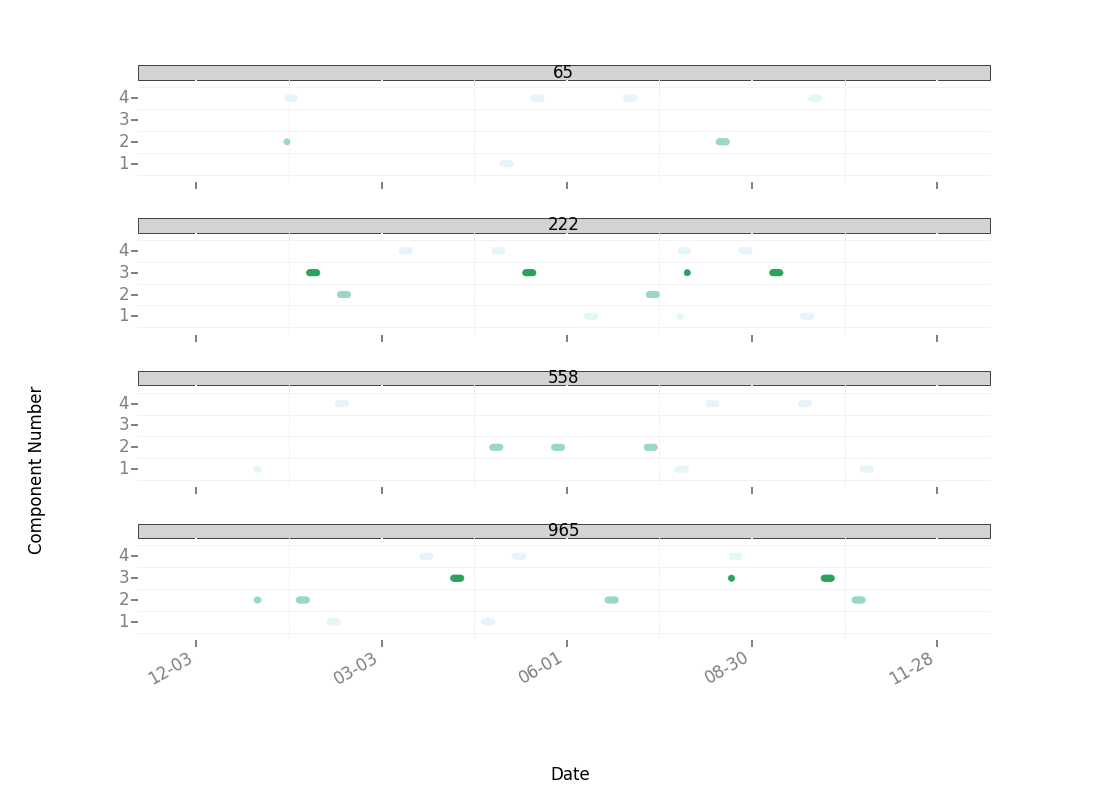

In [32]:

plt_dta = (labeled_features.filter(labeled_features.label_e > 0)
           .where(col("machineID").isin({"65", "558", "222", "965"}))
           .select(labeled_features.machineID, labeled_features.dt_truncated, labeled_features.label_e)
           .toPandas())

# format datetime field which comes in as string
plt_dta['dt_truncated'] = pd.to_datetime(plt_dta['dt_truncated'], format="%Y-%m-%d %H:%M:%S")
plt_dta.label_e = plt_dta.label_e.astype(int)

plt = ggplot(aes(x="dt_truncated", y="label_e", color="label_e"), plt_dta) +\
    geom_point()+\
    xlab("Date") + ylab("Component Number") +\
    scale_x_date(labels=date_format('%m-%d')) +\
    scale_color_brewer(type = 'seq', palette = 'BuGn') +\
    facet_grid('machineID')

display(plt)

Here we see that most of the days are marked as healthy (label = 0 are omitted for plot performance, though the dates are still accurate). Each of the four machines have multiple failures over the course of the dataset. Each labeled failure includes the date of failure and the previous seven days, all are marked with the number indicating the component that failed. 

The goal of the model will be to predict when a failure will occur and which component will fail simultaneously. This will be a multiclass classification problem, though we could pivot the data to individually predict binary failure of a component instead of a machine.

# Conclusion

The next step is to build and compare machine learning models using the feature data set we have just created. The `./notebooks/2b_model_building` notebook builds a Decision Tree Classifier or a Random Forest Classifier using the training data set.